In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from skimage.io import imread
import cv2 

In [2]:
images = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)
images[0]

'/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png'

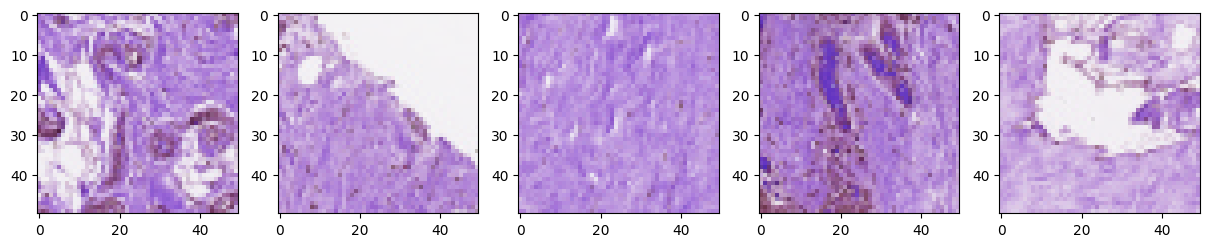

In [3]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  
for i in range(5):
    img = cv2.imread(images[i])
    axes[i].imshow(img) 

In [4]:
df = pd.DataFrame(index=np.arange(0, len(images)), columns=["path", "target"])
for i in range(len(images)):
    df.loc[i, "path"] = images[i]
    df.loc[i, "target"] = int(images[i][-5])

In [5]:
df

,path,target
0,/kaggle/input/breast-histopathology-images/IDC...,0
1,/kaggle/input/breast-histopathology-images/IDC...,0
2,/kaggle/input/breast-histopathology-images/IDC...,0
3,/kaggle/input/breast-histopathology-images/IDC...,0
4,/kaggle/input/breast-histopathology-images/IDC...,0
...,...,...
277519,/kaggle/input/breast-histopathology-images/IDC...,1
277520,/kaggle/input/breast-histopathology-images/IDC...,1
277521,/kaggle/input/breast-histopathology-images/IDC...,1
277522,/kaggle/input/breast-histopathology-images/IDC...,1


In [6]:
pos = df[df.target==1]
neg = df[df.target==0]

In [7]:
pos.shape

(78786, 2)

In [8]:
neg.shape

(198738, 2)

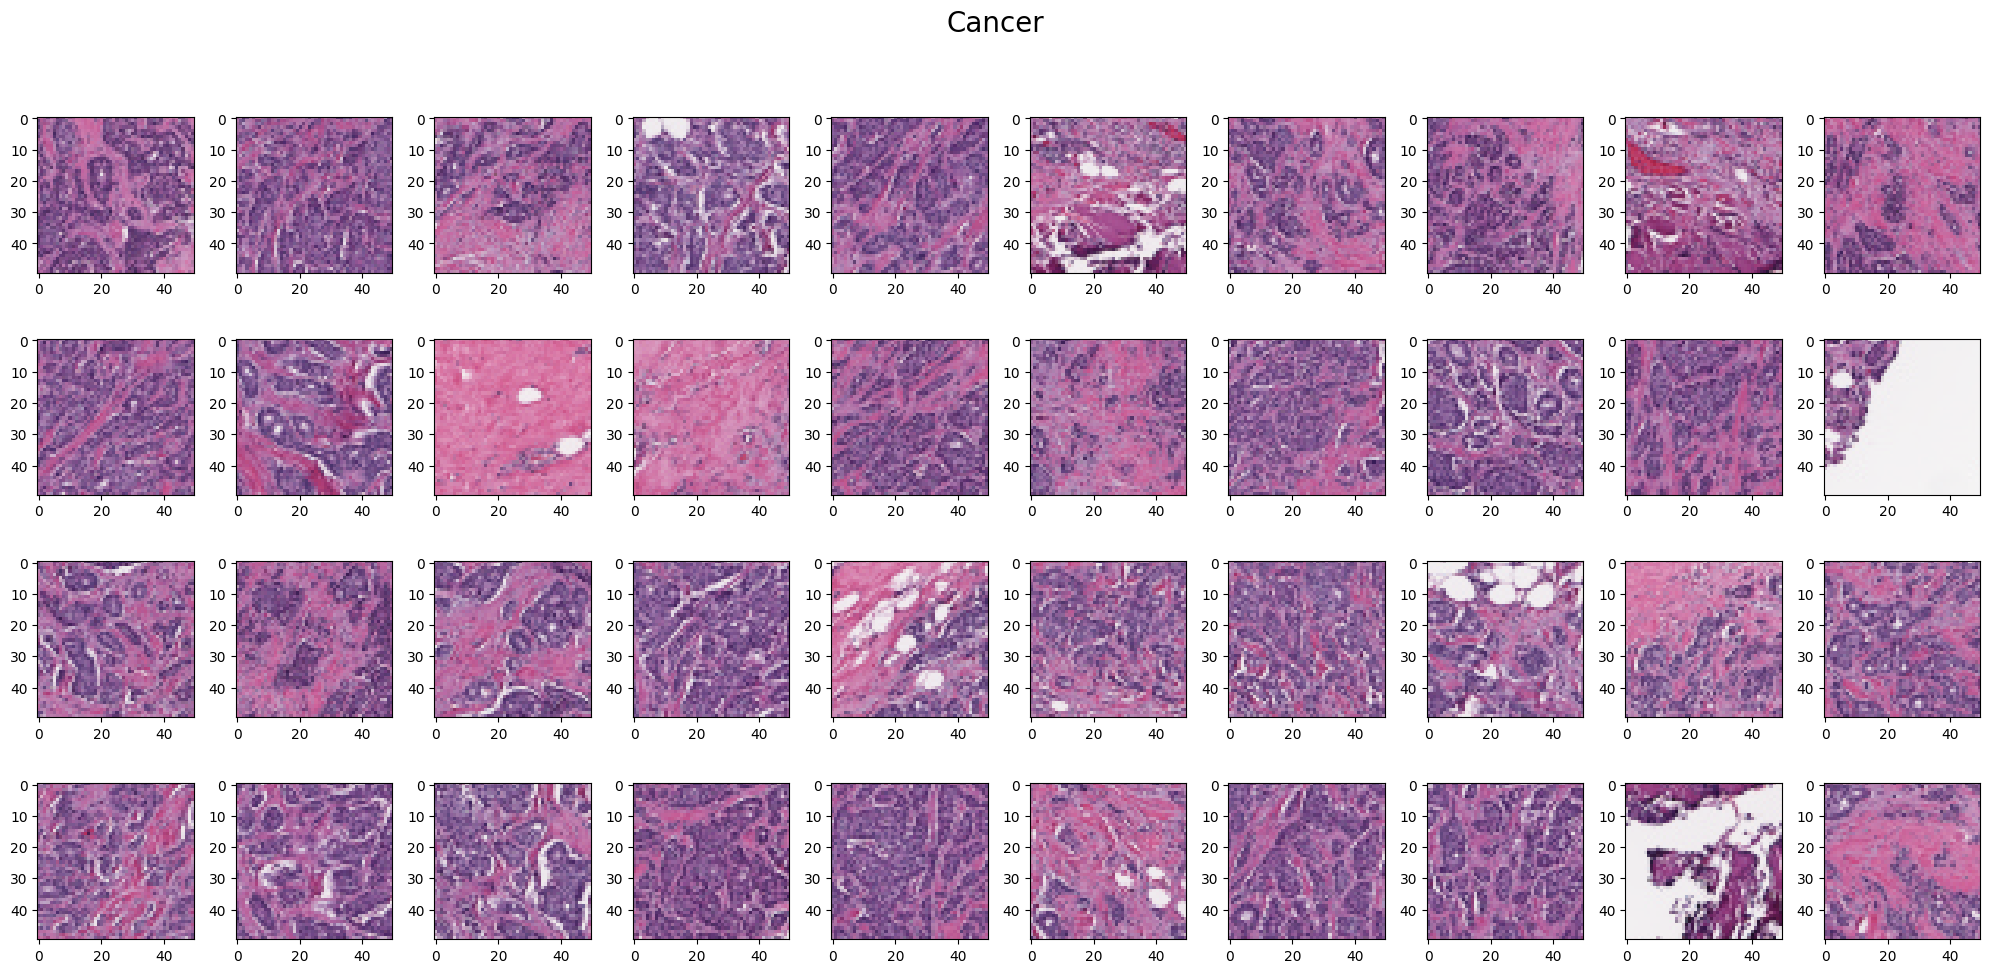

In [9]:
fig, axes = plt.subplots(4, 10, figsize=(20,10))
fig.suptitle('Cancer', fontsize=20)
for i in range(4):
    for j in range(10):        
        image = imread(pos.iloc[j + 10*i]["path"])
        axes[i,j].imshow(image)
plt.tight_layout(rect=[0, 0, 1, 0.96])

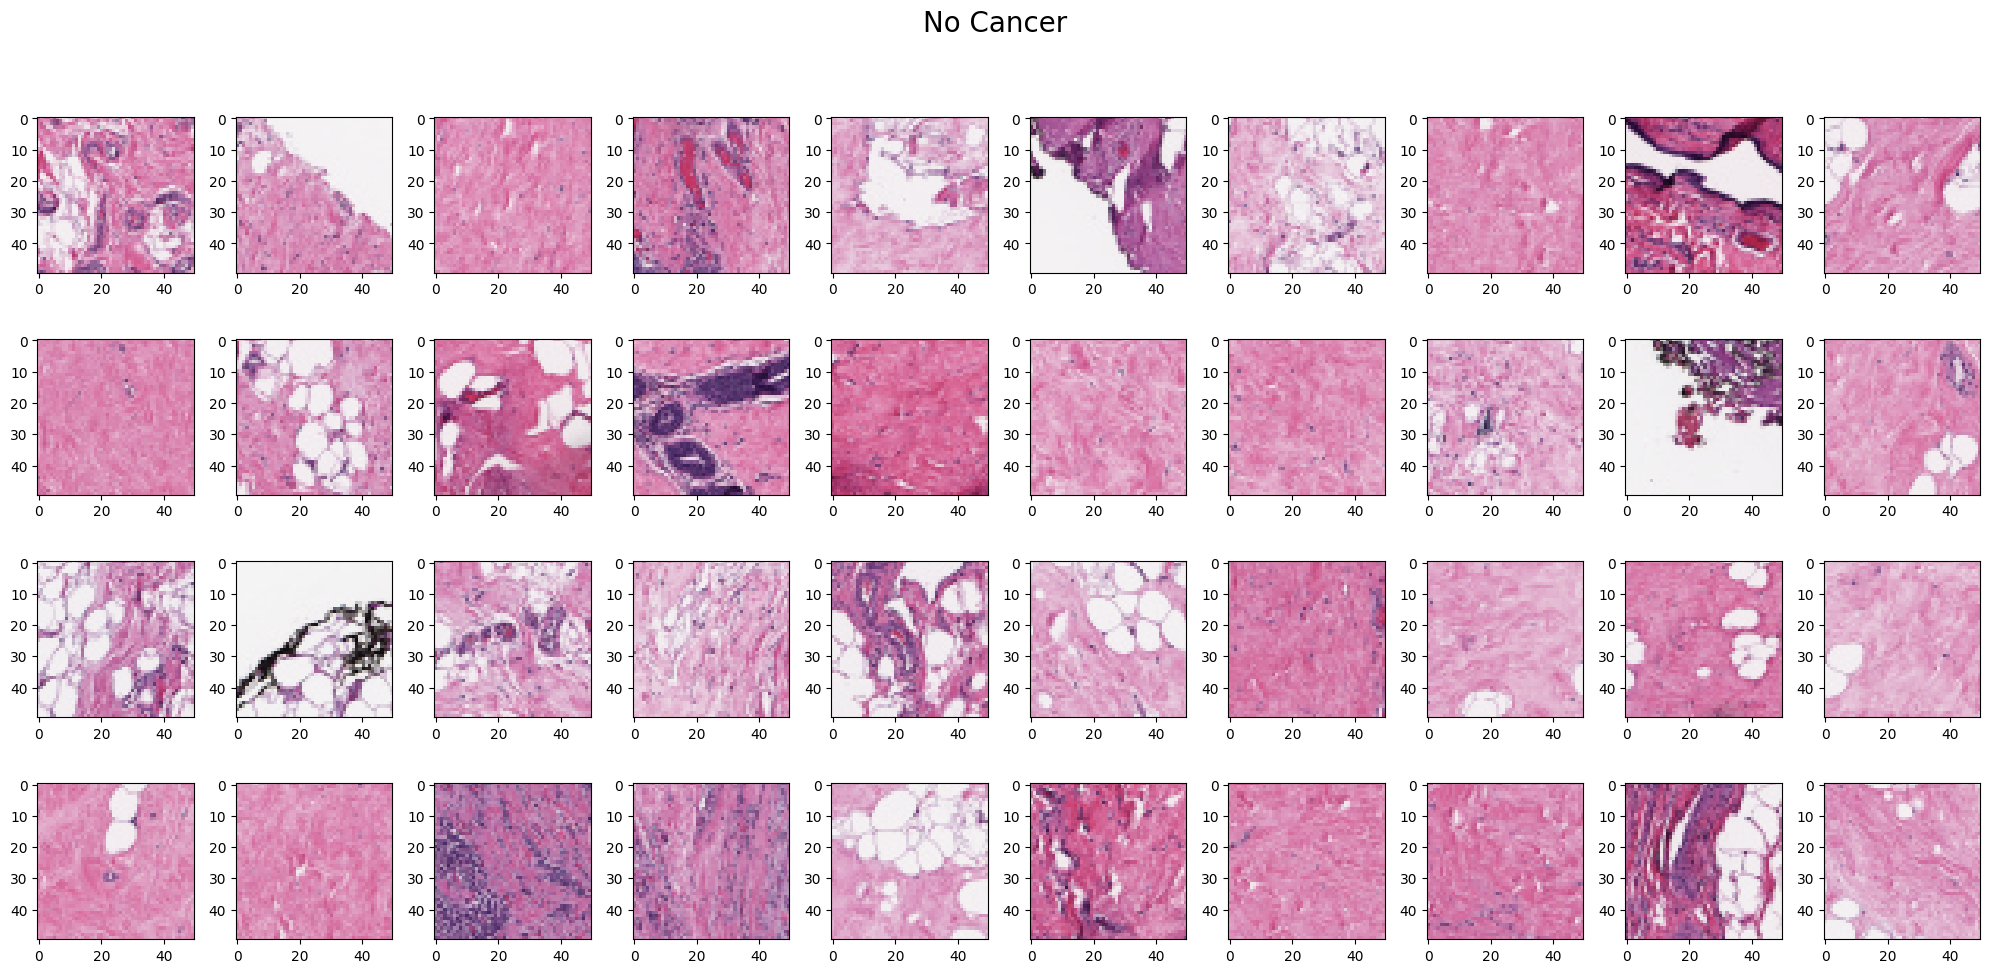

In [10]:
fig, axes = plt.subplots(4, 10, figsize=(20,10))
fig.suptitle('No Cancer', fontsize=20)
for i in range(4):
    for j in range(10):        
        image = imread(neg.iloc[j + 10*i]["path"])
        axes[i,j].imshow(image)
plt.tight_layout(rect=[0, 0, 1, 0.96])

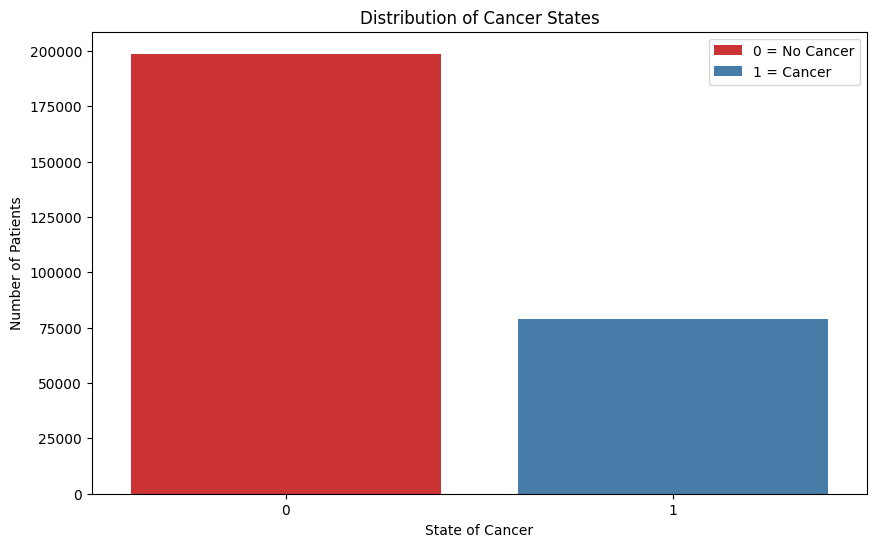

In [11]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=df['target'].value_counts().index, y = df['target'].value_counts(), palette='Set1')
plt.xlabel('State of Cancer')
plt.ylabel('Number of Patients')
plt.title('Distribution of Cancer States')
plt.legend(handles=ax.patches[:2], labels=['0 = No Cancer', '1 = Cancer'], loc='upper right')
plt.show()

In [12]:
from sklearn.utils import resample
pos_balanced = resample(pos,replace=True, n_samples=135000)

In [13]:
df_balanced = pd.concat([neg, pos_balanced])

In [14]:
df_balanced = pd.concat([neg, pos_balanced])

In [15]:
df_balanced.to_csv('balanced_dataframe.csv', index=False)

In [16]:
df_balanced

,path,target
0,/kaggle/input/breast-histopathology-images/IDC...,0
1,/kaggle/input/breast-histopathology-images/IDC...,0
2,/kaggle/input/breast-histopathology-images/IDC...,0
3,/kaggle/input/breast-histopathology-images/IDC...,0
4,/kaggle/input/breast-histopathology-images/IDC...,0
...,...,...
230194,/kaggle/input/breast-histopathology-images/IDC...,1
180403,/kaggle/input/breast-histopathology-images/IDC...,1
88495,/kaggle/input/breast-histopathology-images/IDC...,1
27949,/kaggle/input/breast-histopathology-images/IDC...,1


In [17]:
values = df_balanced.values
np.random.shuffle(values)

In [18]:
X = []
y = []
for feature, label in values:
    image = cv2.imread(feature, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (50, 50), interpolation = cv2.INTER_LINEAR)
    X.append(image)
    y.append(label)
X = np.array(X)
y = np.array(y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [20]:
print(f'Length of Training Data: {len(X_train)}')
print(f'Length of Testing Data: {len(X_test)}')

Length of Training Data: 266990
Length of Testing Data: 66748


In [21]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.utils import to_categorical

In [22]:
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.0001)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 50, 50, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50, 50, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 25, 25, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 25, 25, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,519,298 (9.61 MB)

 Trainable params: 2,518,850 (9.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [25]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping, lr_reduction])

Epoch 1/30
8344/8344 ━━━━━━━━━━━━━━━━━━━━ 50s 5ms/step - accuracy: 0.7561 - loss: 0.6052 - val_accuracy: 0.8039 - val_loss: 0.4323 - learning_rate: 0.0010
Epoch 2/30
8344/8344 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.8064 - loss: 0.4468 - val_accuracy: 0.8050 - val_loss: 0.4525 - learning_rate: 0.0010
Epoch 3/30
8344/8344 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.8172 - loss: 0.4249 - val_accuracy: 0.8210 - val_loss: 0.4081 - learning_rate: 0.0010
Epoch 4/30
8344/8344 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.8266 - loss: 0.4043 - val_accuracy: 0.8148 - val_loss: 0.4047 - learning_rate: 0.0010
Epoch 5/30
8344/8344 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.8342 - loss: 0.3862 - val_accuracy: 0.8158 - val_loss: 0.4004 - learning_rate: 0.0010
Epoch 6/30
8344/8344 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.8401 - loss: 0.3737 - val_accuracy: 0.7776 - val_loss: 0.7147 - learning_rate: 0.0010
Epoch 7/30
8344/8344 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.8

In [26]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
print("Loss:", loss)

2086/2086 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8871 - loss: 0.3936
Test Accuracy: 0.8873374462127686
Loss: 0.38863497972488403


In [27]:
y_pred = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

2086/2086 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
              precision    recall  f1-score   support

           0       0.93      0.88      0.90     39840
           1       0.83      0.90      0.87     26908

    accuracy                           0.89     66748
   macro avg       0.88      0.89      0.88     66748
weighted avg       0.89      0.89      0.89     66748



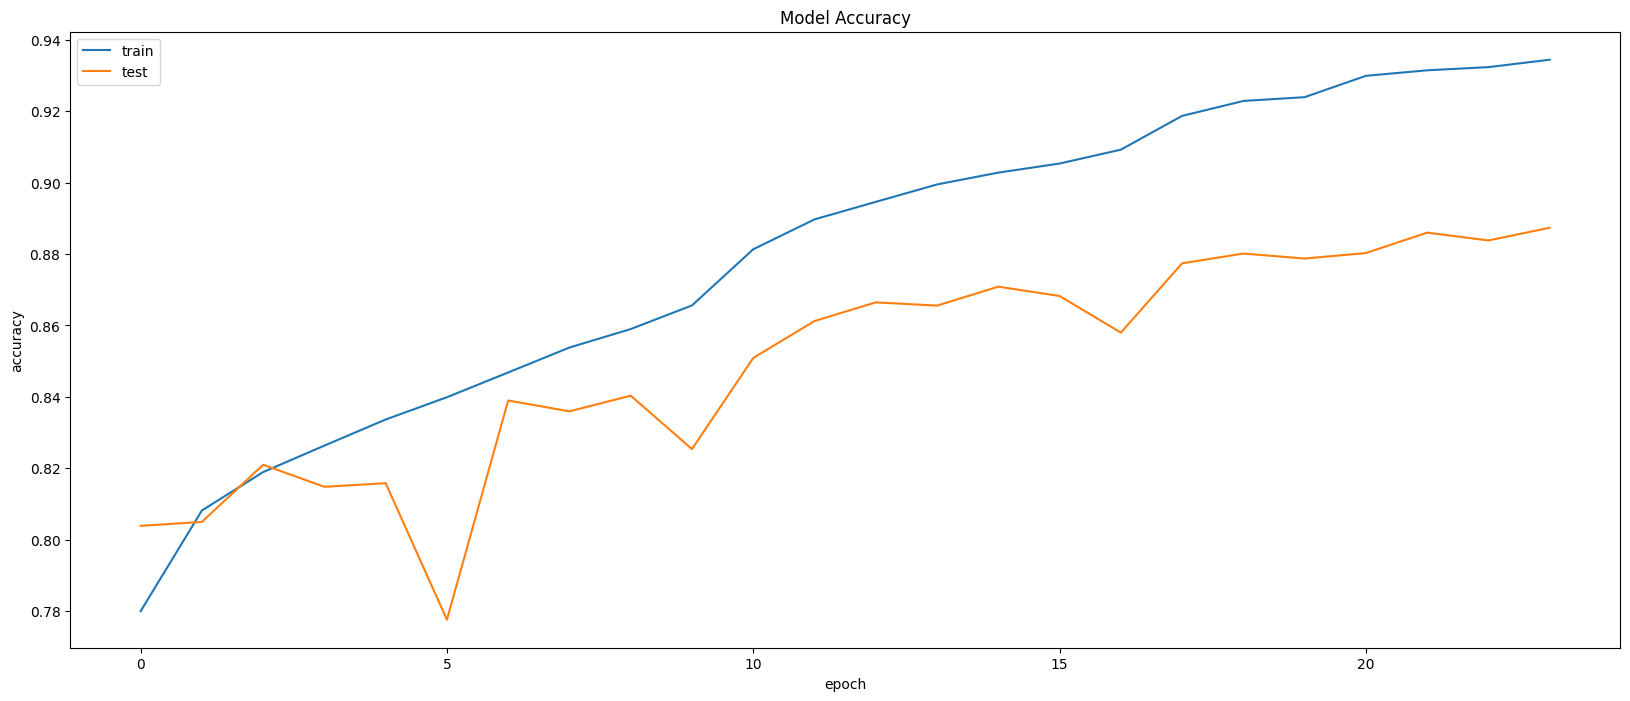

In [28]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

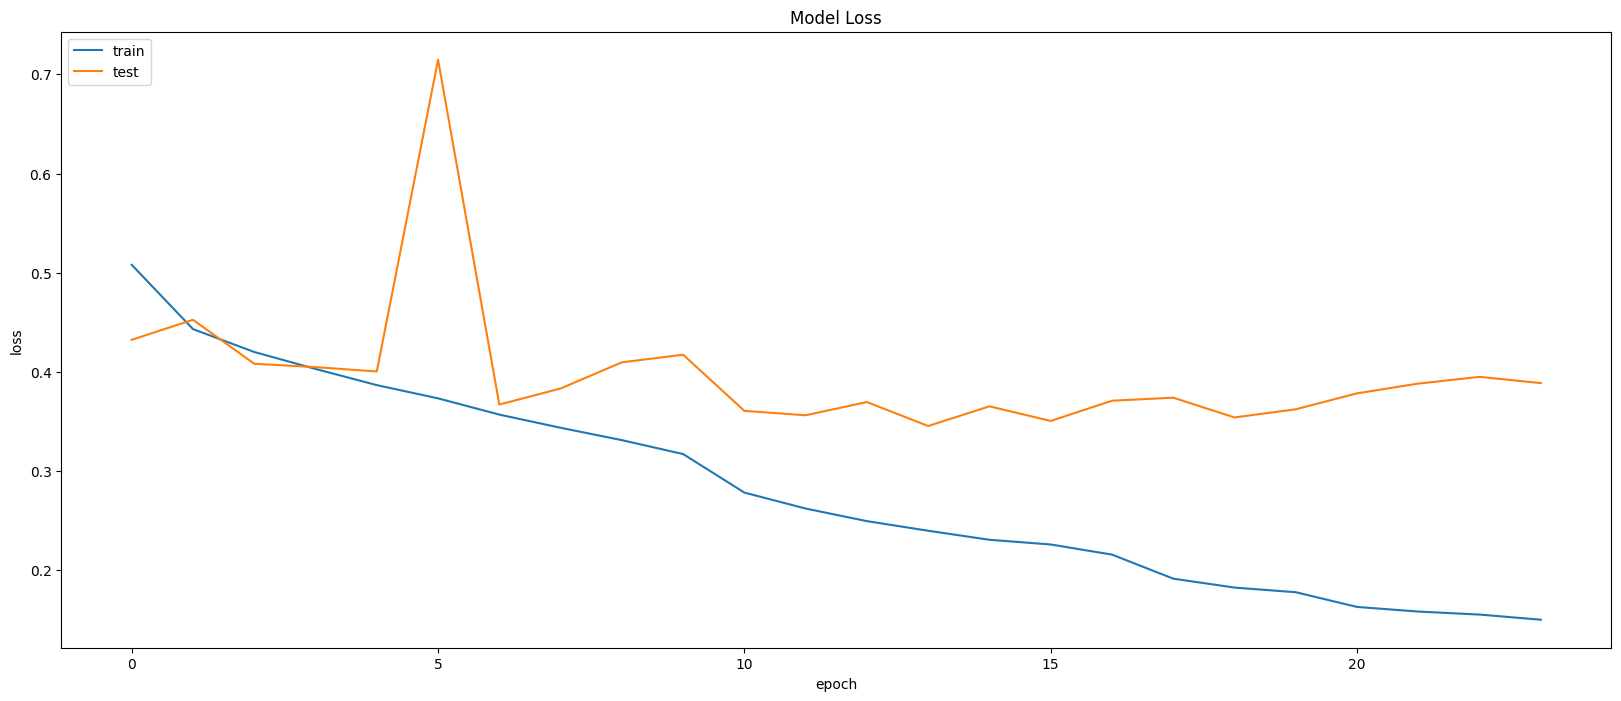

In [29]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()